# Running experiments for our local calibration method

In [3]:
# importing generally used modules
import numpy as np

# for modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory

# data frames and statistics
from scipy import stats
import pandas as pd

# workspace management and counting running time
import os
import time

# graphics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# original directory
path_original = os.getcwd()

# our functions
# both quantile prediction models
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

# non-conformity scores
from lcv.scores import RegressionScore, QuantileScore

# locart method
from lcv.locart import LocartSplit

# figure path
images_dir = "figures"

## Simulated datasets
Now we will consider the same simulated datasets generated by Izbicki et.al (2022) to assess our hypothesis testing framework:

In [4]:
# importing simulated datasets module
from simulation import simulation

# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.4, calibrate = True, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    if calibrate:
        X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.3,
                                                             random_state = random_seed)
        return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}
    else:
        return{"X_train":X_train,"X_test" : X_test, 
                "y_train" : y_train,"y_test": y_test}

We will first compare our method to other conformal and non conformal methods using $S(\boldsymbol{x}, y) = |g(\boldsymbol{x}) - y|$ (Regression score) as our non conformity score:

### Regression Score

We will first focus in comparing these methods on homoscedastisc and heteroscedastic Normal data with noise. But firsst, we test our method using few features as below:

In [3]:
# testing locart split method
d = 5
coef = 3
kind = "homoscedastic"
random_seed = 1250
n = 15000

sim_obj = simulation(dim = d, coef = coef)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_icp = split(sim_obj.X, sim_obj.y, calibrate = True)

In [4]:
locart_obj = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, alpha = 0.05, n_estimators = 200)

Fitting and calibrating:

In [5]:
locart_obj.fit(split_icp["X_train"], split_icp["y_train"])

LocartSplit(alpha=0.05,
            base_model=<class 'sklearn.ensemble._forest.RandomForestRegressor'>,
            nc_score=<lcv.scores.RegressionScore object at 0x7fad383f02e0>)

In [6]:
locart_obj.calib(split_icp["X_calib"], split_icp["y_calib"])

array([0.06912412, 0.03648185, 0.01510839, 0.06120648, 0.08852706,
       0.09679424, 0.05382394, 0.10248027, 0.08900584, 0.20733522,
       0.03187093, 0.02824378, 0.05069097, 0.05682622, 0.07314752,
       0.04775224, 0.09417681, 0.08789713, 0.05146468, 0.13149029,
       0.03949089])

We see that our method seems to work and return diferent thresholds for $t(x)$. So, now we compare our approach to several other commonly used approaches. In order to do that, we define the following functions:

In [5]:
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage(new_X, y_mat[i, :]))  
    return r


def plot_coverage(kind = "homoscedastic", 
           n = 20000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           random_seed = 1250, 
           sig = 0.05,
           alpha = 0.5,
           type_score = "regression",
           base_model = RandomForestRegressor,
           figname_coverage = "coverage_plot.pdf",
           figname_tree = "locart_tree.pdf",
           figname_prediction = "res_pred.pdf",
           split_calib = False,
           plot_tree = True,
           plot_prediction = True,
           criterion = "squared_error",
           max_depth = None,
           max_leaf_nodes = None,
           min_samples_leaf = 100,
           **kwargs):
    
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5,calibrate = False)

    # coverage plot elements
    X_grid = np.linspace(-1.5, 1.5, num = 500)
    X_test = np.ones((500, d))
    X_test[:, 0] = X_grid
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_grid, B = 1000)
    
    if type_score == "regression":
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)
        
        # computing locart coverage for each grid
        locart_real = locart_coverage(locart_obj, X_test, y_mat)
        # fitting icp
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(split_icp["X_train"], split_icp["y_train"])
        icp.calibrate(split_icp["X_test"], split_icp["y_test"])

         # icp
        icp_r_real = real_coverage(icp.predict(X_test, significance = sig), y_mat)

        locart_ave_cover = np.mean(np.abs(locart_real - (1 - sig)))
        icp_ave_cover = np.mean(np.abs(icp_r_real - (1 - sig)))

        #locart
        plt.figure(figsize = (8, 6))
        # ground truth
        plt.plot(X_grid, locart_real, label = "LOCART", color = "royalblue")
        plt.plot(X_grid, icp_r_real, label = "ICP", color = "red")
        plt.xlabel("$x$")
        plt.ylabel("Coverage")
        plt.legend(loc=1)
        plt.savefig(f"{images_dir}/{figname_coverage}")
        plt.show()
    
    
    if plot_tree == True:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    if plot_prediction == True:
        plt.figure(figsize = (8,6 ))
        res_pred = locart_obj.cart.predict(X_test)
        plt.plot(X_grid, res_pred)
        plt.xlabel("$x$")
        plt.ylabel("Non conformity score prediction")
        plt.savefig(f"{images_dir}/{figname_prediction}")
        plt.show()


    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
        gbqr.fit(split_icp["X_train"], split_icp["y_train"])

        # fitting linear quantile regression
        lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
        lqr.fit(split_icp["X_train"], split_icp["y_train"])
    
    return [locart_real, locart_ave_cover, icp_ave_cover]

Now, we will vary several distribution and function parameters and compare our method to the default Split conformal method:

Taking: $d = 1$, $\beta_1 = 2$, Random forest as base model, and not splitting the calibration data, we obtain:

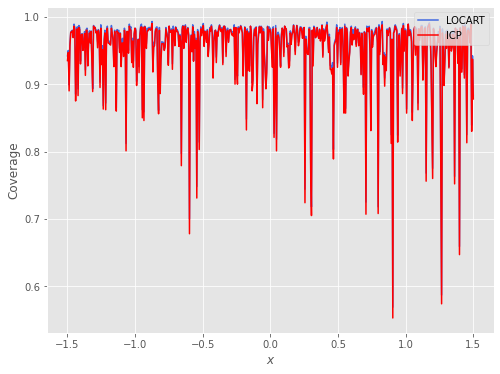

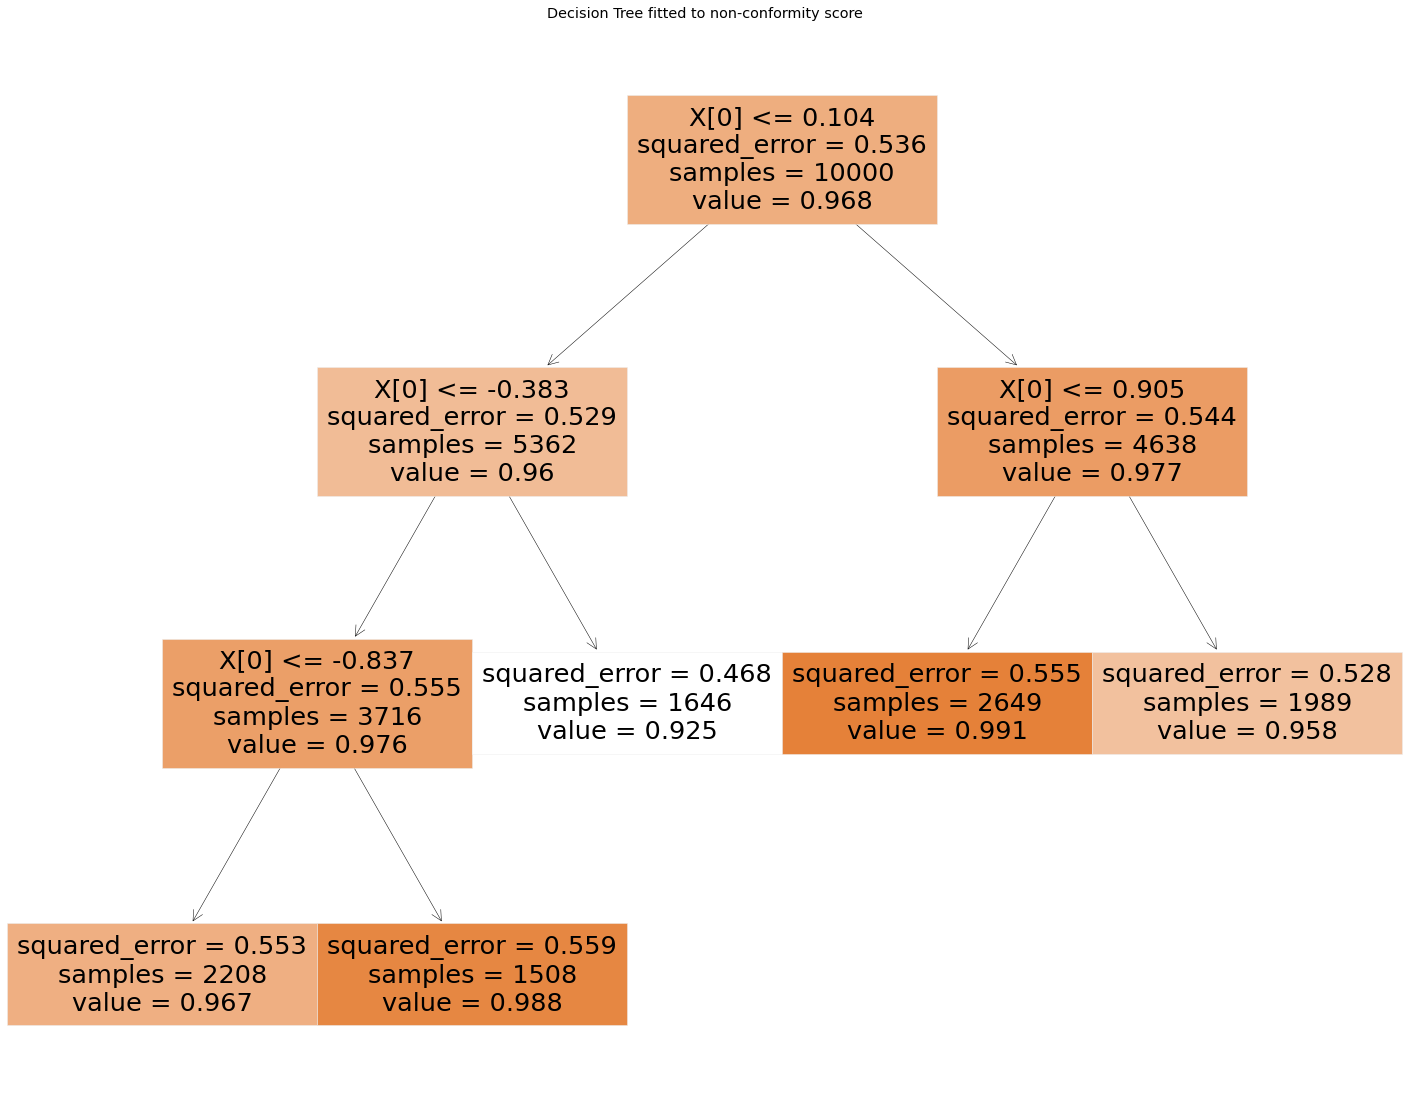

<Figure size 432x288 with 0 Axes>

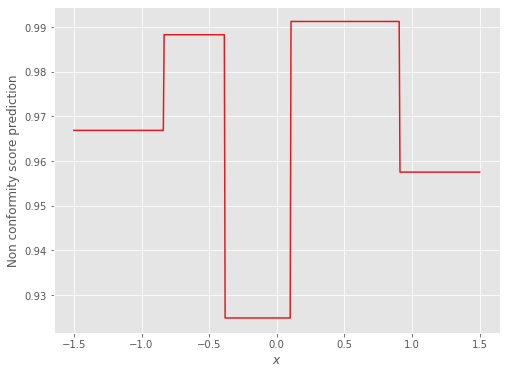

In [28]:
locart_cov_values = plot_coverage(figname_coverage = "coverage_plot_homoscedastic_reg_score_RF_d_1.pdf",
figname_tree = "locart_tree_homoscedastic_RF_d_1.pdf", d = 1, min_samples_leaf = 1500, random_state = 1250)

In [29]:
locart_cov_values[1]

0.035592000000000006

In [30]:
locart_cov_values[2]

0.035856

Splitting calibration data:

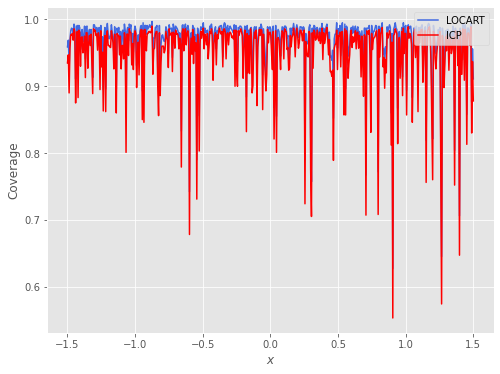

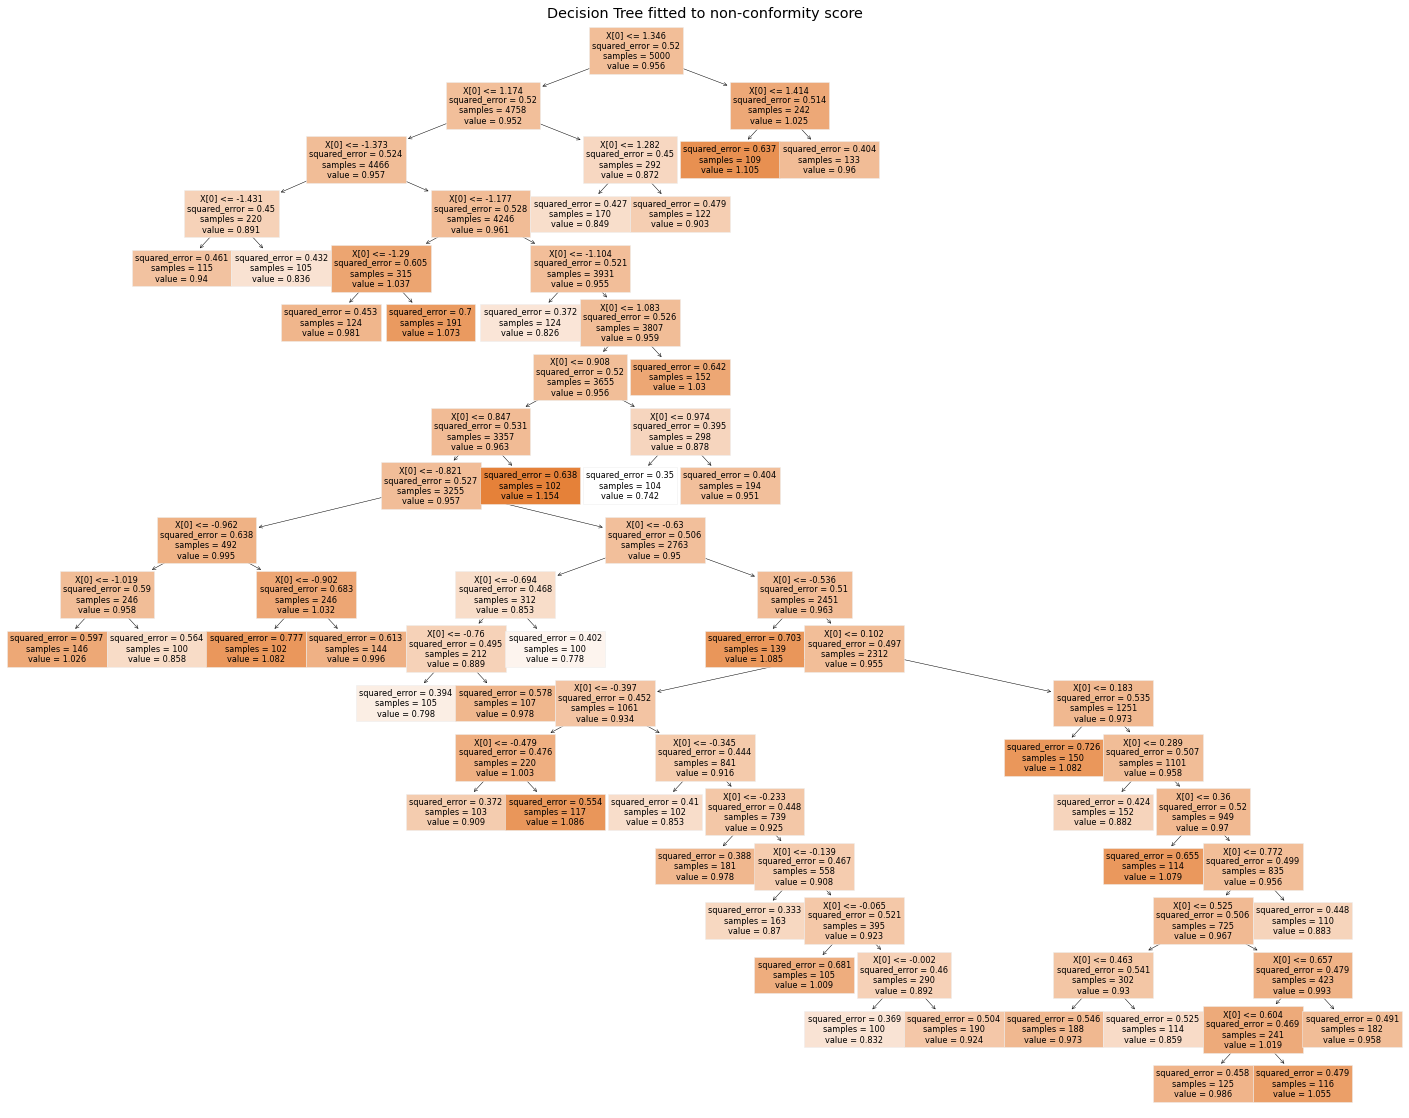

<Figure size 432x288 with 0 Axes>

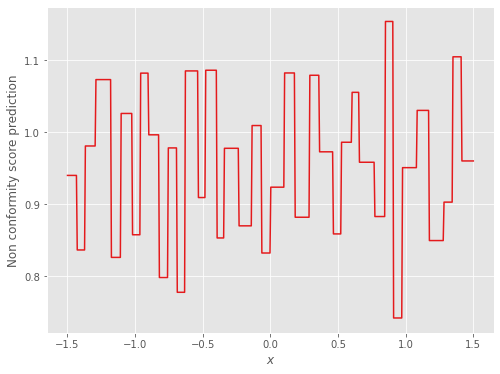

In [22]:
locart_cov_values_split = plot_coverage(figname_coverage = "coverage_plot_homoscedastic_reg_score_RF_d_1_split.pdf",
figname_tree = "locart_tree_homoscedastic_RF_d_1_split.pdf", d = 1, split_calib = True, random_state = 1250)

Checking if the coverage values from locart with and without split are all equal:

In [24]:
np.all(locart_cov_values == locart_cov_values_split)

False

Given that both vectors are not equal, we plot one versus the other now:

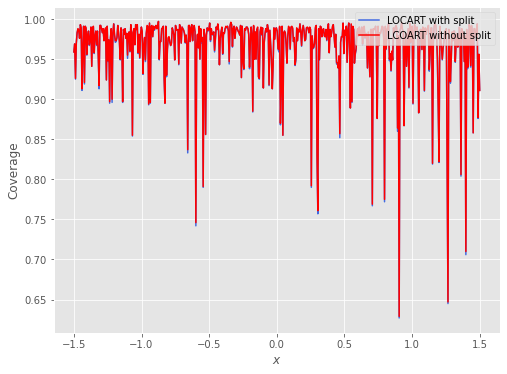

In [23]:
plt.figure(figsize = (8, 6))
# ground truth
X_grid = np.linspace(-1.5, 1.5, num = 500)
plt.plot(X_grid, locart_cov_values_split, label = "LOCART with split", color = "royalblue")
plt.plot(X_grid, locart_cov_values, label = "LCOART without split", color = "red")
plt.xlabel("$x$")
plt.ylabel("Coverage")
plt.legend(loc=1)
plt.show()

Plotting only the split LOCART values:

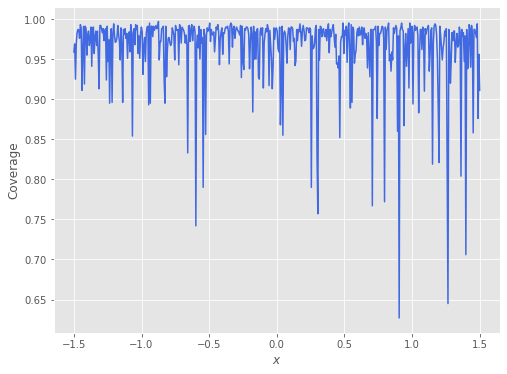

In [25]:
plt.figure(figsize = (8, 6))
# ground truth
X_grid = np.linspace(-1.5, 1.5, num = 500)
plt.plot(X_grid, locart_cov_values_split, label = "LOCART with split", color = "royalblue")
plt.xlabel("$x$")
plt.ylabel("Coverage")
plt.show()

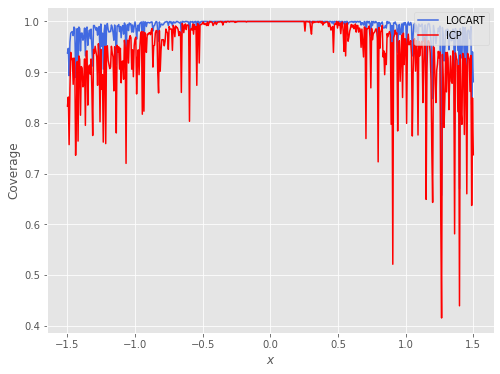

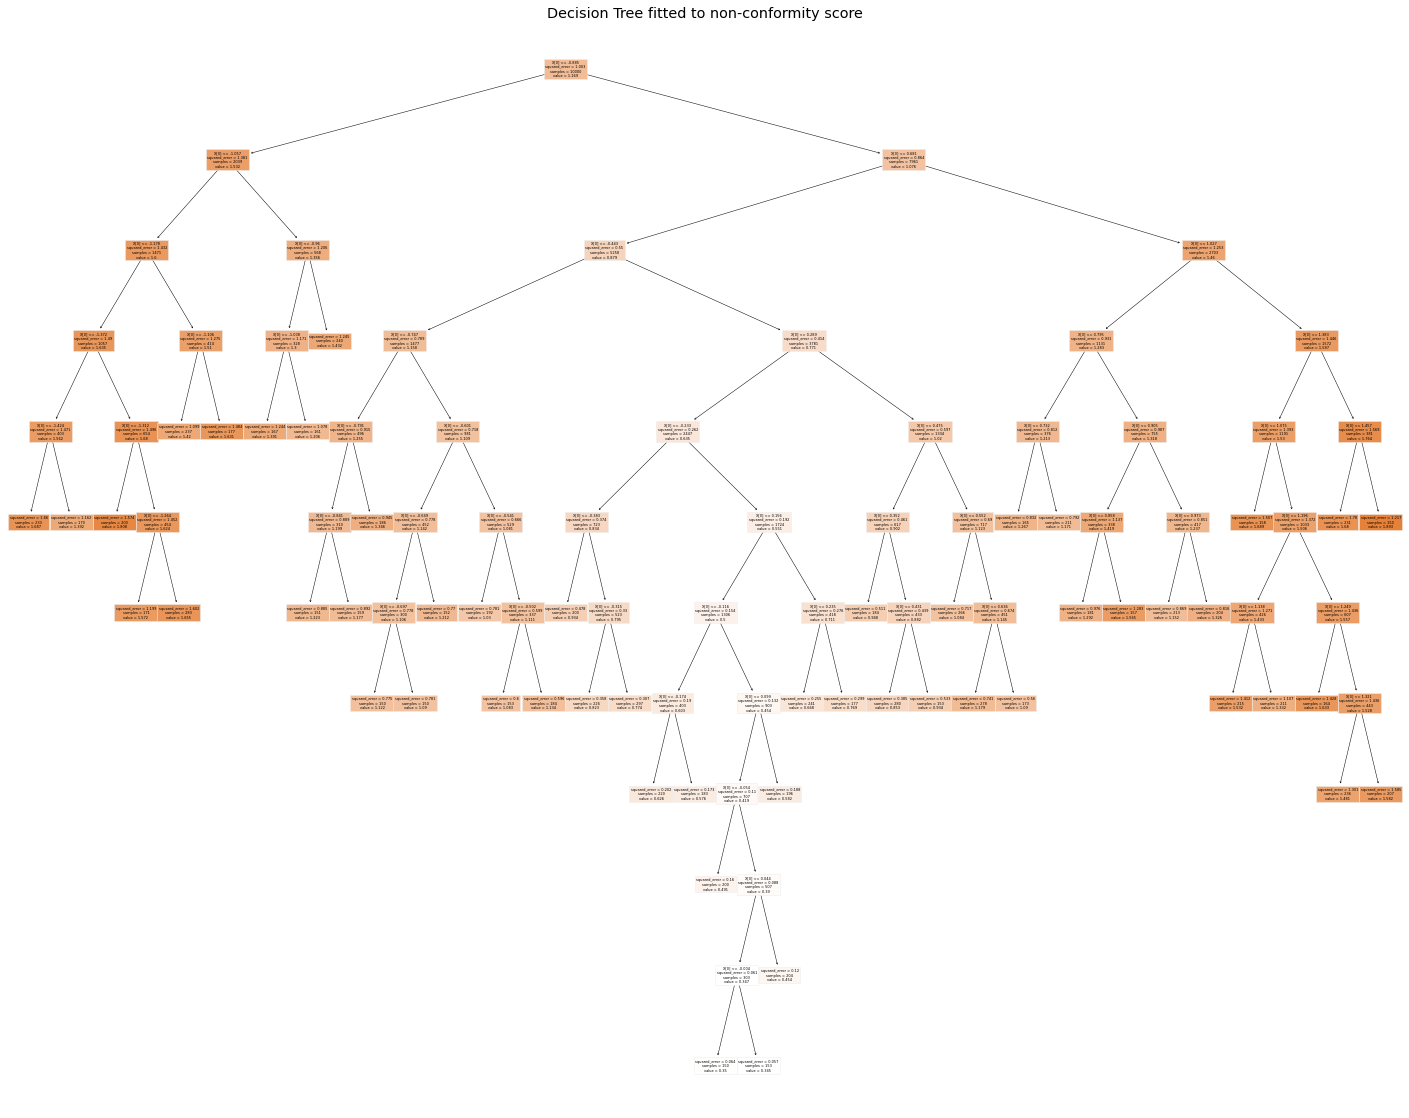

<Figure size 432x288 with 0 Axes>

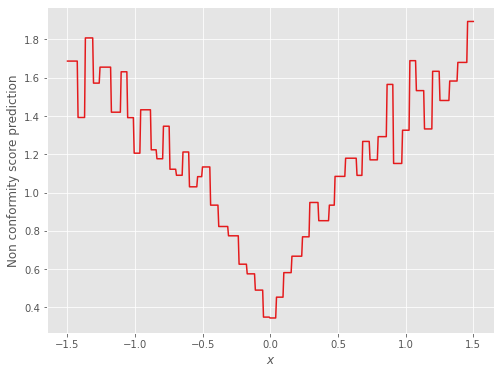

In [6]:
values = plot_coverage(kind = "heteroscedastic", d = 1, figname_coverage = "coverage_plot_heteroscdeastic_reg_score_RF_d_1_split.pdf",
figname_tree = "locart_tree_heteroscedastic_RF_d_1_split.pdf",  min_samples_leaf = 150, hetero_value = 0.1,
random_state = 1250)